## Сбор данных


    Настройка логирования

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, filename="py_log.log",filemode="w",
                    format="%(asctime)s %(levelname)s %(message)s", encoding='UTF-8')


    Импорт базовых бибилотек и функция для обновления токена доступа

In [42]:
import requests

import pandas as pd
import numpy as np

from tqdm import tqdm
from time import sleep

import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

CLIENT_ID = "CLIENT_ID"
CLIENT_SECRET = "CLIENT_SECRET"
REFRESH_TOKEN = "REFRESH_TOKEN"

def refresh_access_token():
    url = "https://accounts.spotify.com/api/token"
    data = {
        "grant_type": "refresh_token",
        "refresh_token": REFRESH_TOKEN,
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET
    }
    response = requests.post(url, data=data)
    return response.json()["access_token"]

In [ ]:
access_token = refresh_access_token()
base_api_url = 'https://api.spotify.com/v1/'
search_api_url = base_api_url+'search'

    Парсинг артистов spotify api
    

In [13]:
def pars_artists():
    artists = []
    for offset in range(0, 200, 50):
        for attempt in range(3):
            try:
                params = {
                    'q' : f'genre:hip hop',
                    'limit': 50,
                    'offset': offset,
                    'type': 'artist',
                }
                page = requests.get(search_api_url,
                                    headers={"Authorization": f"Bearer {access_token}"},
                                    params=params)
                res = page.json()
                items = res['artists']['items']
                artists.extend(items)
                logging.info(f'артисты с {offset} до {offset+50} добавлены')
            except Exception as error:
                logging.error(f"ошибка {error} на попытке {attempt+1}/3")
    logging.info("Все артисты успешно добавлены")
    return artists

In [14]:
artist = pars_artists()

    Парсинг треков по аристам spotify api
    

In [15]:
import requests
from time import sleep

def get_tracks_by_artist(artist):
    tracks = {}
    for offset in range(0, 1000, 50):
        for attempt in range(3):
            try:
                params = {
                    'q': f'artist:{artist}',
                    'limit': 50,
                    'type': 'track',
                    'offset': offset
                    }
                
                page = requests.get(
                    search_api_url,
                    headers={"Authorization": f"Bearer {access_token}"},
                    params=params
                    )

                res = page.json()
                items = res['tracks']['items']
                if not items:
                    logging.warning(f'досрочное завершение парсинга по артисту {artist}')
                    return list(tracks.values())
                    

                for track in items:
                    for track_artists in track['artists']:
                        if track_artists['name'] == artist:
                            tracks[track['id']] = track
                            logging.info(f'трек {track['name']} успешно добавлен')
                            break
                break 

            except Exception as error:
                logging.error(f"Ошибка  {error} на аристе {artist} на попытке {attempt+1}/3")
                sleep(10)
    logging.info('функция успешно завершилась')
    return list(tracks.values())

In [17]:
artists_data = pd.read_csv('datasets/artists_dataset.csv', index_col=0)

In [ ]:
all_tracks = []
c = 0
for artist_id in tqdm(artists_data['name']):
    tracks = get_tracks_by_artist(artist_id)
    all_tracks.extend(tracks)
    c += 1
    if c % 50 == 0:
        access_token = refresh_access_token()
        sleep(2)
    sleep(3)


    Парсинг мелодий с rapid_api по track_id

In [23]:
def pars_rapid_by_track(track_id):
    for attempt in range(3):
        try:
            url = f"https://track-analysis.p.rapidapi.com/pktx/spotify/{track_id}"
            headers = {
                        "x-rapidapi-key": "x-rapidapi-key",
                        "x-rapidapi-host": "x-rapidapi-host",   
                       }
            sleep(3)
            page = requests.get(url, headers=headers, timeout=10)
            if page.status_code != 200:
                logging.warning(f"Ответ {page.status_code},  для трека {track_id} на попытке {attempt+1}/3")
                sleep(5)
                continue

            data = page.json()
            logging.info(f"информация по песне {track_id} добавлена")
            return data
        except Exception as error:
            logging.error(f'Ошибка {error} на песне {track_id} на попытке {attempt+1}/3')
            sleep(2)
            
    logging.critical(f'Информация по песне {track_id} не найдена, она будет пропущена')
    return {'id': None,
  'key': None,
  'mode': None,
  'camelot': None,
  'tempo': None,
  'duration': None,
  'popularity': None,
  'energy': None,
  'danceability': None,
  'happiness': None,
  'acousticness': None,
  'instrumentalness': None,
  'liveness': None,
  'speechiness': None,
  'loudness': None}
        

    Подготовка для скраппинга

In [20]:
tracks_data = pd.read_csv('datasets/tracks_dataset.csv', index_col=0)

In [ ]:
tracks_info = []

for i in tqdm(range(len(tracks_data['id']))):
    info = pars_rapid_by_track(tracks_data['id'][i])
    tracks_info.append(info)
    sleep(3)

In [21]:
melodies = pd.read_csv('datasets/melodies.csv', index_col=0)

In [26]:
tracks = pd.read_csv('datasets/tracks_dataset.csv')
tracks = tracks.rename(columns={'artists' : "artists_ids", 'id' : 'track_id'})
tracks = tracks.drop(columns={'Unnamed: 0'})

In [27]:
def remove_feats(song_name):
    if '(' in song_name:
        start = song_name.find('(')
        finish = song_name.find(')')
        song_name = song_name[:start] + song_name[finish+1:]
    return song_name

def prepare_song_name(row):
    name = row['track_name']
    row['track_name'] = remove_feats(name)
    return row


def set_only_first_artist(artists):
    if ',' in artists:
        index = artists.find(',')
        artists = artists[:index]
    return artists

def prepare_artists_names(row):
    name = row['artists_names']
    row['artists_names'] = set_only_first_artist(name)
    return row

In [ ]:
tracks_for_genius = pd.merge(tracks, artists_tracks, left_on='track_id', right_on='track_id', how='left')
tracks_for_genius = tracks_for_genius.drop(columns=['name_x'])
tracks_for_genius = tracks_for_genius.rename(columns={'name_y' : 'track_name'})
tracks_for_genius = tracks_for_genius.sort_values(by='popularity', ascending=False)
tracks_for_genius = tracks_for_genius[~tracks_for_genius['artists_names'].isna()]
tracks_for_genius = tracks_for_genius.apply(prepare_song_name, axis=1)
tracks_for_genius = tracks_for_genius.reset_index(drop=True)
tracks_for_genius

In [33]:
from selenium import webdriver as wd
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import Keys
from bs4 import BeautifulSoup
from tqdm import tqdm


options = wd.ChromeOptions()
options.page_load_strategy = 'eager'
options.add_argument('--disable-blink-features=AutomatisationControlled') 
options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36') 
options.add_argument("--disable-features=VizDisplayCompositor")
options.add_argument("--disable-images")

    Скраппинг genius по названиям треков и аристам


In [ ]:
driver = wd.Chrome(options=options)
driver.get('https://genius.com/')
driver.implicitly_wait(4)
driver.set_script_timeout(5)
wait=WebDriverWait(driver=driver, timeout=3, poll_frequency=1)

texts = []


for i in tqdm(range(len(tracks_for_genius))):
                        
    SONG_NAME_INPUT = ('xpath', '//input[@name="q"]')
    SEARCH_BUTTON = ('xpath', '//div[@class="global_search-submit_button u-clickable"]')
    try:
        for att in range(5):
            try:
                driver.get('https://genius.com/')
                time.sleep(1.5)
                driver.find_element(*SONG_NAME_INPUT).send_keys(tracks_for_genius[i])
                time.sleep(1.5)
                driver.find_element(*SONG_NAME_INPUT).send_keys(Keys.ENTER)
                WebDriverWait(driver, 5).until(EC.url_changes('https://genius.com/'))
                time.sleep(1.6)
                break
            except Exception as ex:
                logging.error(f'Error: {ex} for input name -  {tracks_for_genius[i].upper()}')
                continue
    except Exception as ex:
        logging.error(f'Error: {ex} - text not added for - {tracks_for_genius[i].upper()}')
        texts.append(None)
        continue
                
        
    SONGS_BLOCK = ('xpath', "//div[contains(@class, 'search_results_label') and text()='Songs']")
    is_song_block = driver.find_elements(*SONGS_BLOCK)
    
    if is_song_block:
        SONG_CARDS = ('xpath', '//div[text()="Songs"]/following::div[1]')
        song_cards = driver.find_element(*SONG_CARDS)
        html_song_cards = driver.execute_script('return arguments[0].outerHTML', song_cards)
        for atts in range(3):
             try:
                current_url = driver.current_url
                TOP_SONG_CARD = ('xpath', f'//div[text()="Songs"]/following::mini-song-card[{check_lang(html_song_cards)+1}]')
                wait.until(EC.visibility_of_element_located(TOP_SONG_CARD)).click()
                WebDriverWait(driver, 5).until(EC.url_changes(current_url))
                CONTAINER = ('xpath', '(//div[@class="Lyrics__Container-sc-cbcfa1dc-1 dfzvqs"])')

                elements = driver.find_elements(*CONTAINER)
                text=''
                for el in elements:
                    html_el = driver.execute_script('return arguments[0].outerHTML', el)


                    soup = BeautifulSoup(html_el, 'html.parser')
                    lyrics_container = soup.find("div", {"data-lyrics-container": "true"})

                    text_piece = lyrics_container.get_text(separator="\n", strip=True)
                    text+=(text_piece + '\n')

                texts.append(text)
                logging.info(f'Text added {i} - for {tracks_for_genius[i]}')
                break
             except Exception as ex:
                  continue
    else:
        texts.append(None)
        logging.info(f'No text {i} - for {tracks_for_genius[i]}')
        




driver.quit()
len(texts)


## EDA

    Подготовка текста

In [36]:
df = pd.read_csv('datasets/tracks_texts.csv', index_col=0)

In [37]:
def Processing(text):
    try:
        if text == "":
            logging.warning("Получен пустой текст")
            return ""
        text = text.lower() #привели к нижнему регистру
        #очистим метаинформацию и оставим только текст
        text = re.sub(r'^.*?(\[)', r'\1', text, flags=re.DOTALL) #находим первую квадратную скобку и удаляем все до нее
        #флаг re.DOTALL нужен для того чтобы точка рассчитывалась как любой символ(для того чтобы находило перевод строки)
        return text
    except Exception as e:
        logging.error(f"Ошибка в Processing: {e}")
        return ""
df['texts'] = df['texts'].apply(lambda x: Processing(x))

In [38]:
def NewFeatures(df):
    try:
        logging.info(f"Начинаем вычисление фич для текста треков")
        
        df['Amount_words'] = df['texts'].apply(lambda x: CountWords(x))
        logging.info("Вычислен Amount_words")
        
        df['Amount_unique_words'] = df['texts'].apply(lambda x: CountUniqueWords(x))
        logging.info("Вычислен Amount_unique_words")
        
        df['Diversity_coeff'] = df['texts'].apply(lambda x: DiversityCoeff(x))
        logging.info("Вычислен Diversity_coeff")
        
        df['Amount_adlibs'] = df['texts'].apply(lambda x: CountAdlibs(x))
        logging.info("Вычислен Amound_adlibs")

        df['Amount_verses'] = df['texts'].apply(lambda x: CountVerse(x))
        logging.info("Вычислен Amount_verses")

        df['Amount_chorusOLD'] = df['texts'].apply(lambda x: CountChorus(x))
        logging.info("Вычислено Amount_chorus")

        df['Avg_words_verse'] = df['texts'].apply(lambda x: AvgWordsVerse(x))
        logging.info("Вычислено Avg_words_verse")

        logging.info("Все фичи успешно добавлены в датасет")
        return df
        
    except Exception as e:
        logging.error(f"Ошибка в функции NewFeatures: {e}")
        raise

def CleanText(text):
    try:
        if text == "":
            logging.warning("Получен пустой текст в CountWords")
            return ""
        
        cleaned_text = re.sub(r'\[.*?\]\n?', '', text, flags=re.DOTALL) #удаляем содержимое квадратных скобок
        cleaned_text = re.sub(r'[()]', '', cleaned_text) #удаляем круглые скобки

        words = cleaned_text.split()
        return words
    except Exception as e:
        logging.error(f"Ошибка в CleanText: {e}")
        return []
    
def CountWords(text):
    try:    
        words = CleanText(text)
        word_count = len(words)
        
        return word_count
        
    except Exception as e:
        logging.error(f"Ошибка в CountWords: {e}")
        return 0

def CountUniqueWords(text):
    try:    
        words = CleanText(text)
        unique_count = len(set(words))
        
        return unique_count
        
    except Exception as e:
        logging.error(f"Ошибка в CountUniqueWords: {e}")
        return 0

def DiversityCoeff(text):
    try:
        words_count = CountWords(text)
        unique_count = CountUniqueWords(text)
            
        diversity = words_count / unique_count
        return diversity
        
    except Exception as e:
        logging.error(f"Ошибка в DiversityCoeff: {e}")
        return 0
    
def CountAdlibs(text):
    try:
        if text == "":
            logging.warning("Получен пустой текст в CountAdlibs")
            return 0
        cleaned_text = re.sub(r'\[.*?\]\n?', '', text, flags=re.DOTALL) #удаляем содержимое квадратных скобок
        counter = 0
        for char in cleaned_text:
            if char == '(':
                counter += 1
        return counter
    except Exception as e:
        logging.error(f"Ошибка в CountAdlibs: {e}")
        return 0
    
def CountChorus(text):
    try:
        if text == "":
            logging.warning("Получен пустой текст в CountChorus")
            return 0
        
        pattern = r'\[(?:chorus|estribillo)[^\]]*\]'
        matches = re.findall(pattern, text, re.IGNORECASE)
        
        return len(matches)
    
    except Exception as e:
        logging.error(f"Ошибка в CountChorus: {e}")
        return 0


def CountVerse(text):
    try:
        if text == "":
            return 0
        
        pattern = r'\[(?:verse|verso)[^\]]*\]'
        matches = re.findall(pattern, text, re.IGNORECASE)
        return len(matches)
    
    except Exception as e:
        logging.error(f"Ошибка в CountVerse: {e}")
        return 0


def AvgWordsVerse(text):
    try:
        if text == "":
            logging.warning("Получен пустой текст в AvgWordsChorus")
            return 0

        verse_count = CountVerse(text)
        if verse_count == 0:
            logging.info("Verse не найден в тексте")
            return 0

        pattern = r'\[(?:verse|verso)[^\]]*\]([^\]]*?)(?=\[|$)'
        matches = re.findall(pattern, text, re.DOTALL)
        sum_words = 0
        for match in matches:
            cleaned_text = re.sub(r'[()]', '', match)
            words = cleaned_text.split()
            sum_words += len(words)

        return sum_words // verse_count
        
    except Exception as e:
        logging.error(f"Ошибка в AvgWordsVerse: {e}")
        return 0

In [ ]:
NewFeatures(df)  

In [43]:
ta_data = pd.read_csv('datasets/tracks_dataset.csv').drop(columns='Unnamed: 0')

In [44]:
markets_data = ta_data[['id','available_markets']]
markets_data= markets_data.rename(columns = {'available_markets' : 'markets'})
markets_data

,id,markets
0,5qu4lGjCcqQzPEs10f1hfj,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA..."
1,0XcPDJvfuwgLUYHavU7LiS,"['AD', 'AE', 'AM', 'AR', 'AT', 'AU', 'BA', 'BE..."
2,31lXE9pDnGGinifKgfFzbW,"['AU', 'AT', 'BE', 'BG', 'CY', 'CZ', 'DK', 'DE..."
3,12cbGuaFcoYfBnWKDj9hzP,"['AU', 'AT', 'BE', 'BG', 'CY', 'CZ', 'DK', 'DE..."
4,1aPhom57yPUoaYMA4LGYjq,"['AM', 'AT', 'AU', 'AZ', 'BE', 'BF', 'BG', 'BN..."
...,...,...
35548,7lQ8MOhq6IN2w8EYcFNSUk,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA..."
35549,1zi7xx7UVEFkmKfv06H8x0,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA..."
35550,7KA4W4McWYRpgf0fWsJZWB,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA..."
35551,6xV7Be6XEvkSnighmh2Tzj,"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA..."


In [45]:
def token_market_func(row):
    marks = row['markets']
    marks = marks[1:-1]
    marks = marks.replace("'", '')
    marks = marks.split(", ")
    row['markets'] = marks
    return row

markets_data = markets_data.apply(token_market_func, axis=1)

In [46]:
def count_num_of_markets(row):
    row['num_of_markets'] = len(row['markets'])
    return row

markets_data['num_of_markets']=0
markets_data = markets_data.apply(count_num_of_markets, axis=1)


In [47]:
markets_data[['markets']]['markets'].explode().unique().size # всего 185 возможных стран

185

In [48]:
country_codes = {
    'AR': 'ARG', 'AU': 'AUS', 'AT': 'AUT', 'BE': 'BEL', 'BO': 'BOL', 
    'BR': 'BRA', 'BG': 'BGR', 'CA': 'CAN', 'CL': 'CHL', 'CO': 'COL', 
    'CR': 'CRI', 'CY': 'CYP', 'CZ': 'CZE', 'DK': 'DNK', 'DO': 'DOM', 
    'DE': 'DEU', 'EC': 'ECU', 'EE': 'EST', 'SV': 'SLV', 'FI': 'FIN', 
    'FR': 'FRA', 'GR': 'GRC', 'GT': 'GTM', 'HN': 'HND', 'HK': 'HKG', 
    'HU': 'HUN', 'IS': 'ISL', 'IE': 'IRL', 'IT': 'ITA', 'LV': 'LVA', 
    'LT': 'LTU', 'LU': 'LUX', 'MY': 'MYS', 'MT': 'MLT', 'MX': 'MEX', 
    'NL': 'NLD', 'NZ': 'NZL', 'NI': 'NIC', 'NO': 'NOR', 'PA': 'PAN', 
    'PY': 'PRY', 'PE': 'PER', 'PH': 'PHL', 'PL': 'POL', 'PT': 'PRT', 
    'SG': 'SGP', 'SK': 'SVK', 'ES': 'ESP', 'SE': 'SWE', 'CH': 'CHE', 
    'TW': 'TWN', 'TR': 'TUR', 'UY': 'URY', 'US': 'USA', 'GB': 'GBR', 
    'AD': 'AND', 'LI': 'LIE', 'MC': 'MCO', 'ID': 'IDN', 'JP': 'JPN', 
    'TH': 'THA', 'VN': 'VNM', 'RO': 'ROU', 'IL': 'ISR', 'ZA': 'ZAF', 
    'SA': 'SAU', 'AE': 'ARE', 'BH': 'BHR', 'QA': 'QAT', 'OM': 'OMN', 
    'KW': 'KWT', 'EG': 'EGY', 'MA': 'MAR', 'DZ': 'DZA', 'TN': 'TUN', 
    'LB': 'LBN', 'JO': 'JOR', 'PS': 'PSE', 'IN': 'IND', 'BY': 'BLR', 
    'KZ': 'KAZ', 'MD': 'MDA', 'UA': 'UKR', 'AL': 'ALB', 'BA': 'BIH', 
    'HR': 'HRV', 'ME': 'MNE', 'MK': 'MKD', 'RS': 'SRB', 'SI': 'SVN', 
    'KR': 'KOR', 'BD': 'BGD', 'PK': 'PAK', 'LK': 'LKA', 'GH': 'GHA', 
    'KE': 'KEN', 'NG': 'NGA', 'TZ': 'TZA', 'UG': 'UGA', 'AG': 'ATG', 
    'AM': 'ARM', 'BS': 'BHS', 'BB': 'BRB', 'BZ': 'BLZ', 'BT': 'BTN', 
    'BW': 'BWA', 'BF': 'BFA', 'CV': 'CPV', 'CW': 'CUW', 'DM': 'DMA', 
    'FJ': 'FJI', 'GM': 'GMB', 'GE': 'GEO', 'GD': 'GRD', 'GW': 'GNB', 
    'GY': 'GUY', 'HT': 'HTI', 'JM': 'JAM', 'KI': 'KIR', 'LS': 'LSO', 
    'LR': 'LBR', 'MW': 'MWI', 'MV': 'MDV', 'ML': 'MLI', 'MH': 'MHL', 
    'FM': 'FSM', 'NA': 'NAM', 'NR': 'NRU', 'NE': 'NER', 'PW': 'PLW', 
    'PG': 'PNG', 'PR': 'PRI', 'WS': 'WSM', 'SM': 'SMR', 'ST': 'STP', 
    'SN': 'SEN', 'SC': 'SYC', 'SL': 'SLE', 'SB': 'SLB', 'KN': 'KNA', 
    'LC': 'LCA', 'VC': 'VCT', 'SR': 'SUR', 'TL': 'TLS', 'TO': 'TON', 
    'TT': 'TTO', 'TV': 'TUV', 'VU': 'VUT', 'AZ': 'AZE', 'BN': 'BRN', 
    'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR', 'TD': 'TCD', 'KM': 'COM', 
    'GQ': 'GNQ', 'SZ': 'SWZ', 'GA': 'GAB', 'GN': 'GIN', 'KG': 'KGZ', 
    'LA': 'LAO', 'MO': 'MAC', 'MR': 'MRT', 'MN': 'MNG', 'NP': 'NPL', 
    'RW': 'RWA', 'TG': 'TGO', 'UZ': 'UZB', 'ZW': 'ZWE', 'BJ': 'BEN', 
    'MG': 'MDG', 'MU': 'MUS', 'MZ': 'MOZ', 'AO': 'AGO', 'CI': 'CIV', 
    'DJ': 'DJI', 'ZM': 'ZMB', 'CD': 'COD', 'CG': 'COG', 'IQ': 'IRQ', 
    'LY': 'LBY', 'TJ': 'TJK', 'VE': 'VEN', 'ET': 'ETH', 'XK': 'XKX'
}

In [49]:
all_m = markets_data[['markets']]['markets'].explode().reset_index(drop=True)

In [50]:
all_m = all_m.value_counts().reset_index()
all_m

,markets,count
0,NG,35553
1,ZA,35505
2,MU,35392
3,CM,35353
4,KE,35341
...,...,...
180,UZ,33898
181,BF,33683
182,BN,33574
183,BY,28179


In [51]:
def rename_countries(row):
    row['markets'] = country_codes[row['markets']]
    return row

all_m = all_m.apply(rename_countries, axis=1)

In [52]:
all_m = all_m.rename(columns={'count' : 'Count'})

In [53]:
fig = px.choropleth(
    all_m,
    locations='markets',        # колонка с кодами стран ISO-3
    color='Count',             # колонка с числом треков
    hover_name='markets',       # что показывать при наведении
    color_continuous_scale='Viridis',
    title='Распределение треков по странам'
)



fig.update_layout(
    title_x=0.45,
    font={"size":16}
)

fig.show()

In [54]:
data = pd.read_csv('datasets/data_upd.csv', index_col=0)

/var/folders/m5/s_f0fwv138n0r7f6kbff113w0000gn/T/ipykernel_36072/3385831233.py:1: DtypeWarning:

Columns (11,20) have mixed types. Specify dtype option on import or set low_memory=False.



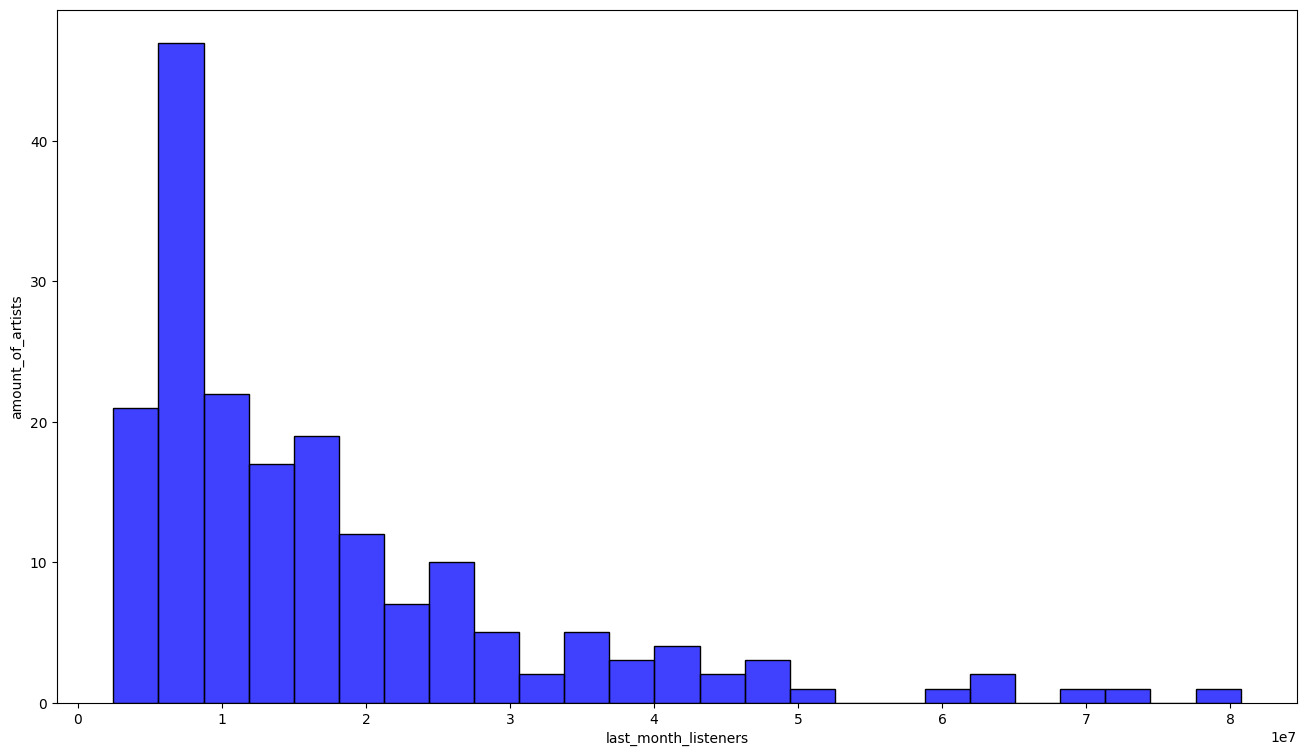

In [56]:
plt.figure(figsize=(16,9))
sns.histplot(
    data=artists_data,
    x='last_month_listeners',
    color='blue', 
    bins=25)

plt.title("", fontweight='bold')
plt.xlabel("last_month_listeners")
plt.ylabel("amount_of_artists")
plt.show()

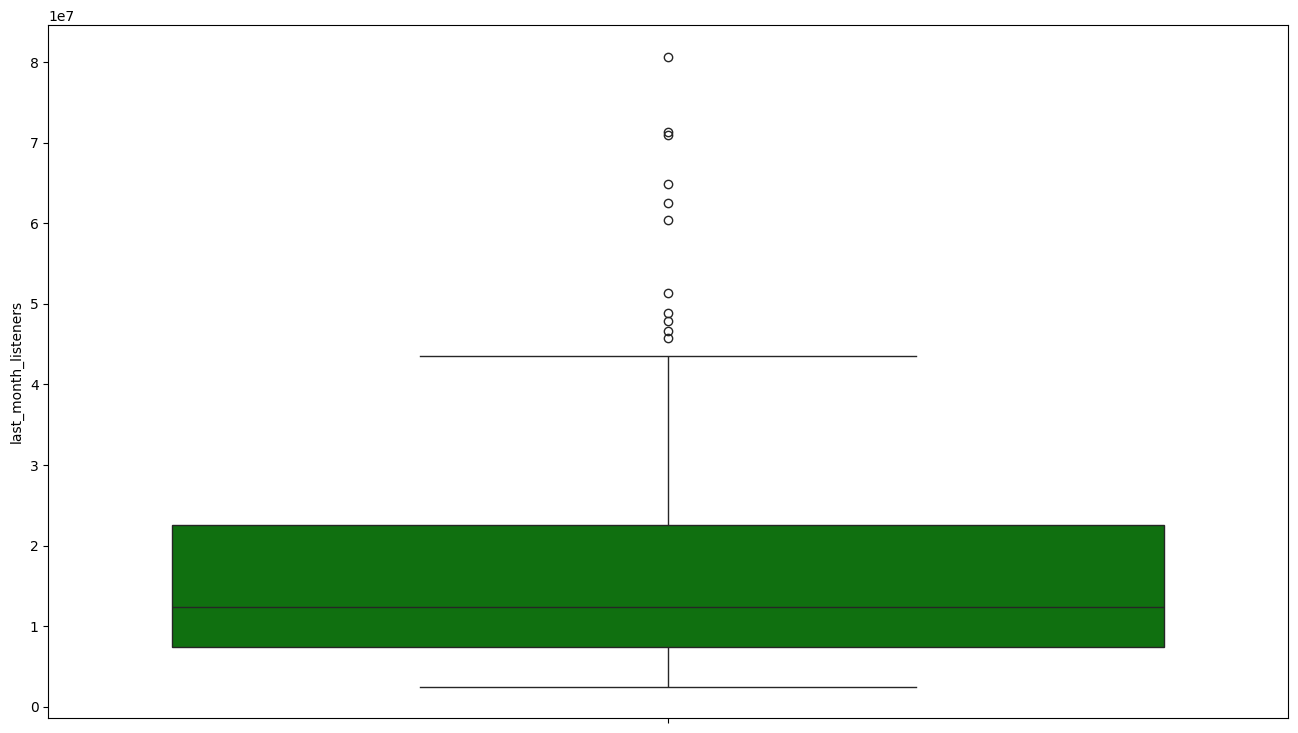

In [61]:
plt.figure(figsize=(16,9))
sns.boxplot(
    data=artists_data,
    y='last_month_listeners',
    color='green')

plt.title("", fontweight='bold')
plt.ylabel("last_month_listeners")
plt.show()

In [57]:
artists_data1 = artists_data[artists_data['last_month_listeners'] < artists_data['last_month_listeners'].quantile(0.9)]

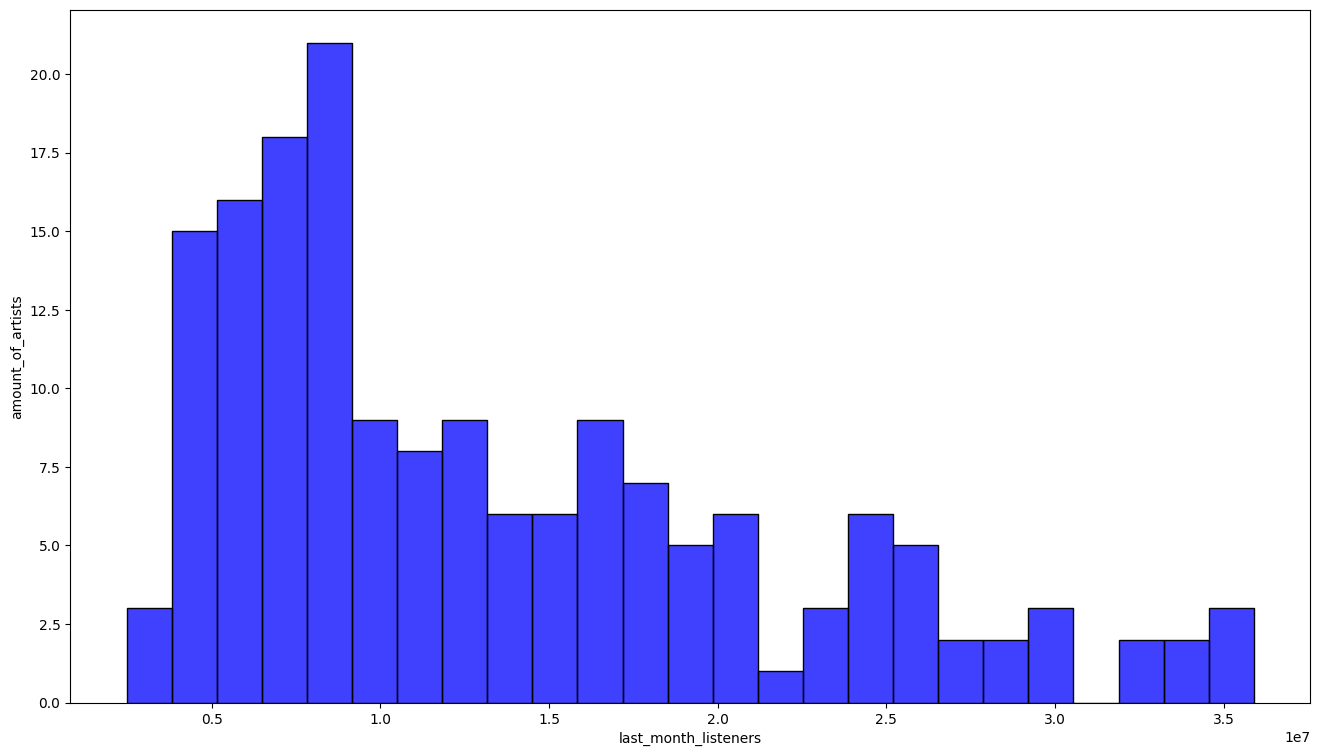

In [58]:
plt.figure(figsize=(16,9))
sns.histplot(
    data=artists_data1,
    x='last_month_listeners',
    color='blue',
    bins=25)

plt.title("", fontweight='bold')
plt.xlabel("last_month_listeners")
plt.ylabel("amount_of_artists")
plt.show()

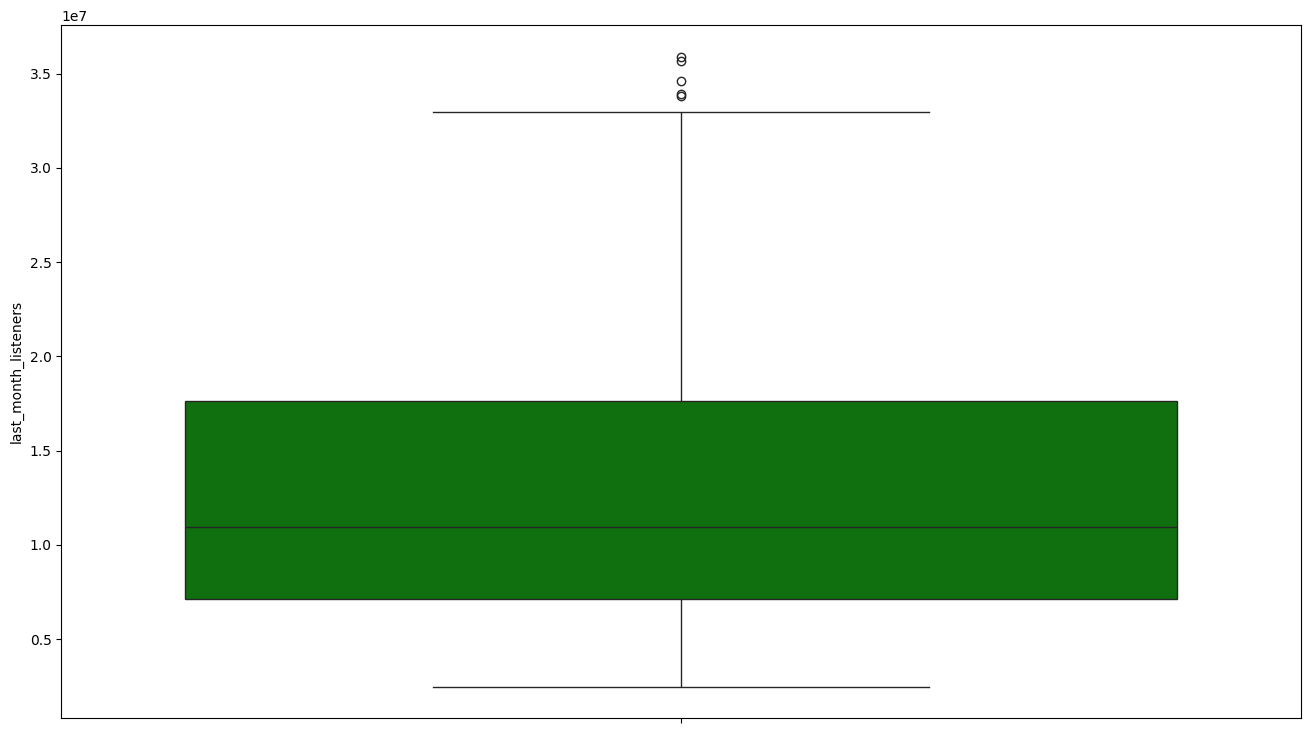

In [60]:
plt.figure(figsize=(16,9))
sns.boxplot(
    data=artists_data1,
    y='last_month_listeners',
    color='green')

plt.title("", fontweight='bold')
plt.ylabel("last_month_listeners")
plt.show()

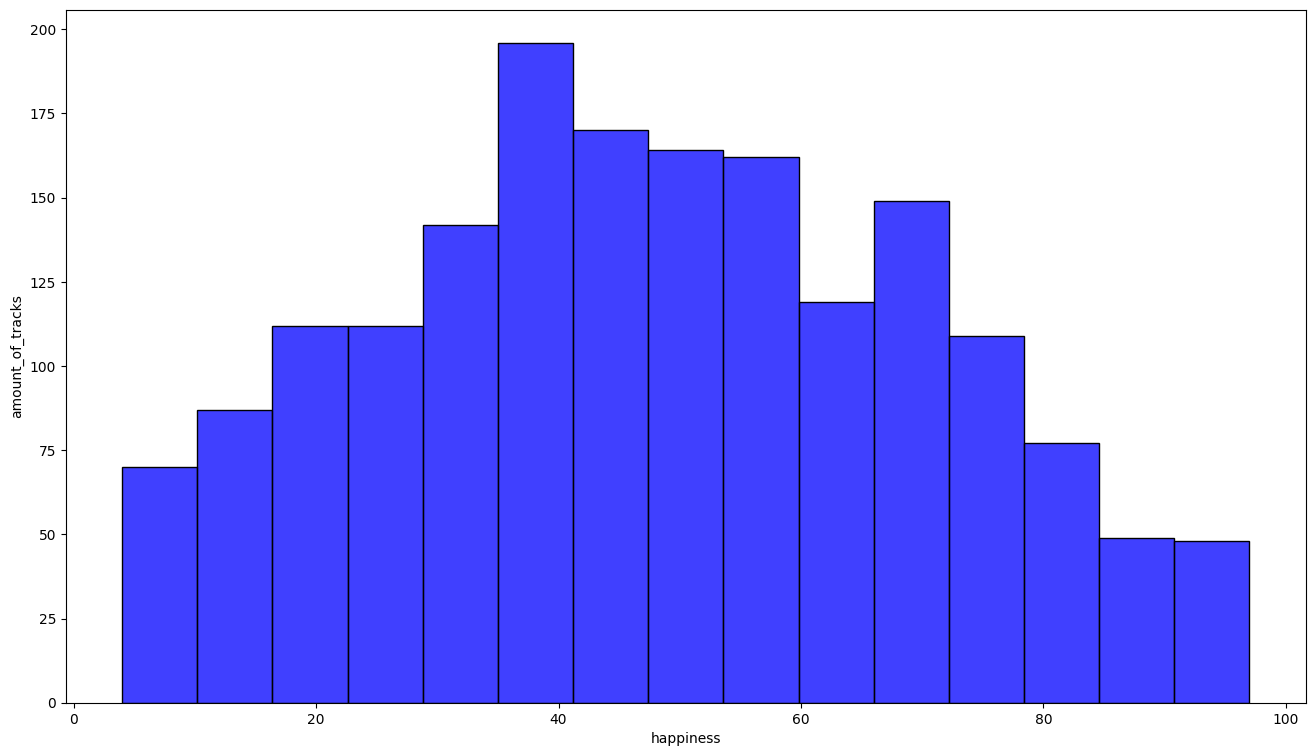

In [62]:
plt.figure(figsize=(16,9))
sns.histplot(
    data=melodies,
    x='happiness',
    color='blue',
    bins=15)

plt.title("", fontweight='bold')
plt.xlabel("happiness")
plt.ylabel("amount_of_tracks")
plt.show()

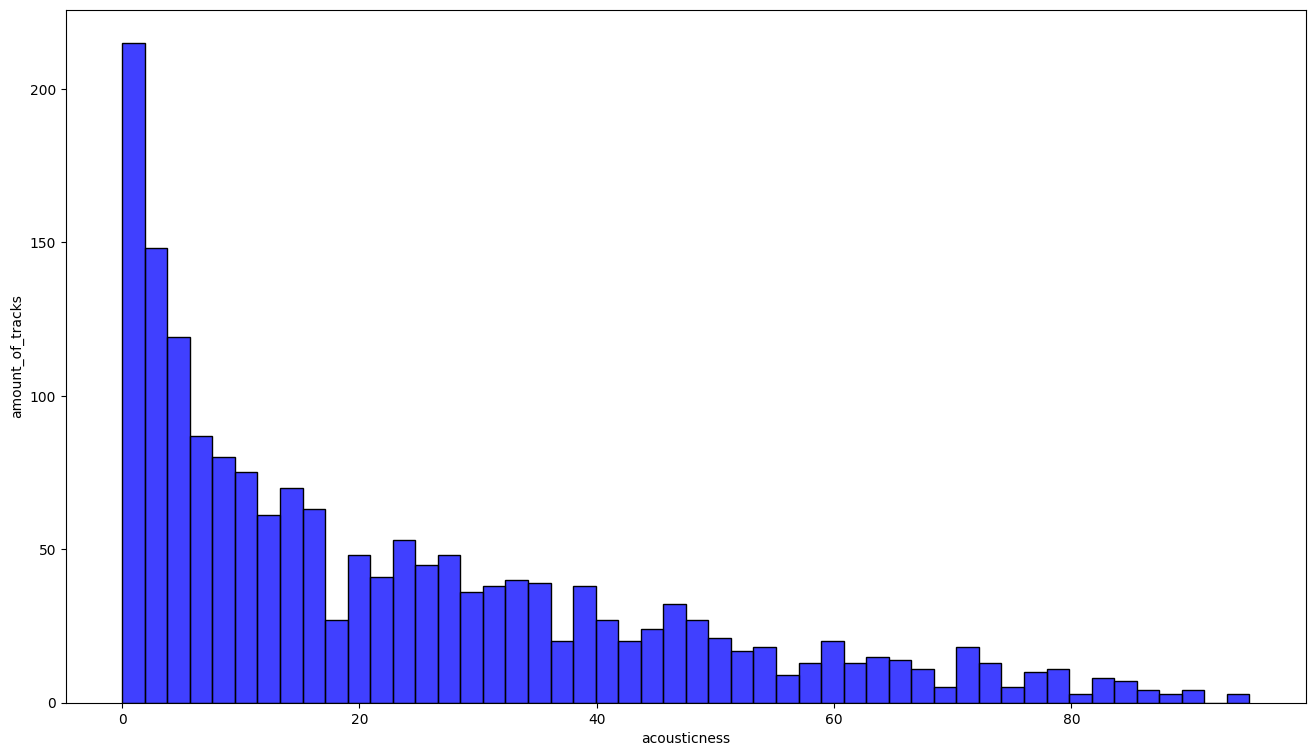

In [63]:
plt.figure(figsize=(16,9))
sns.histplot(
    data=melodies,
    x='acousticness',
    color='blue',
    bins=50)

plt.title("", fontweight='bold')
plt.xlabel("acousticness")
plt.ylabel("amount_of_tracks")
plt.show()

In [65]:
lyrics = pd.read_csv('datasets/lirycs_stats.csv', index_col=0)

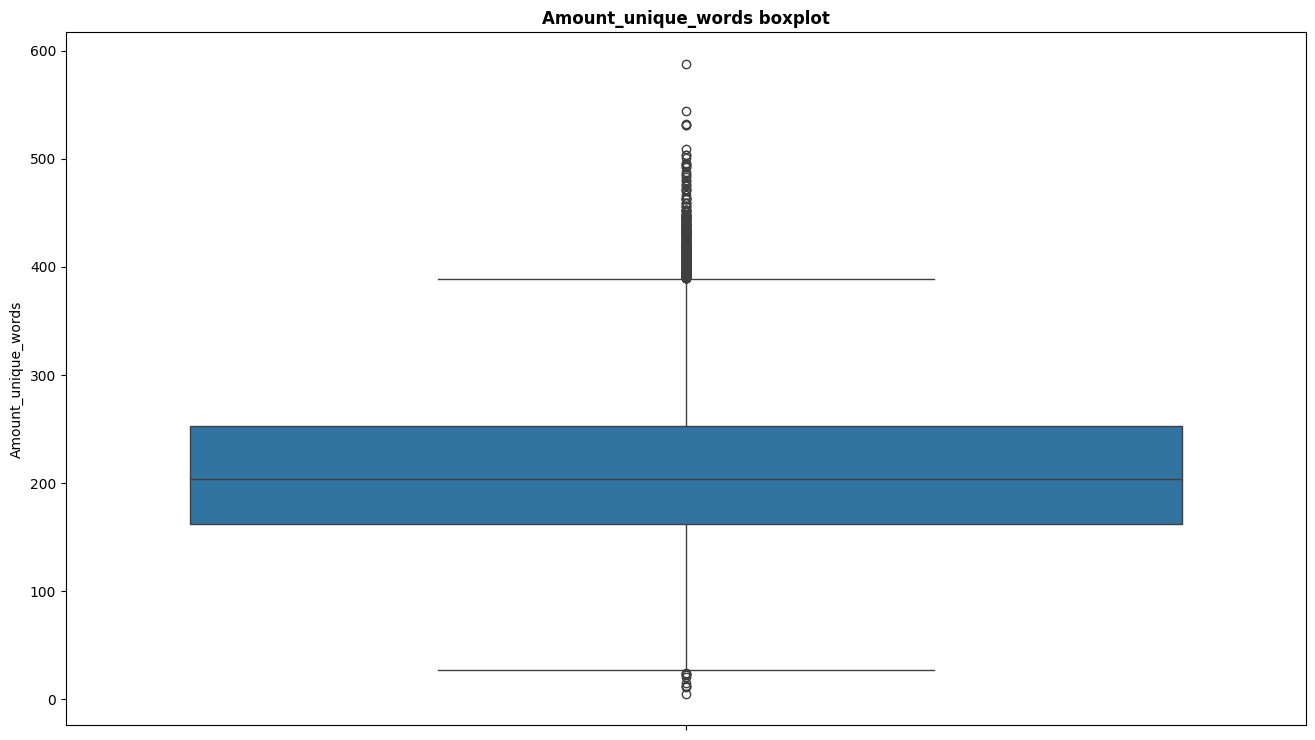

In [75]:
plt.figure(figsize=(16,9))
sns.boxplot(
    data=lyrics,
    y='Amount_unique_words')

plt.title("Amount_unique_words boxplot", fontweight='bold')
plt.ylabel("Amount_unique_words")
plt.show()

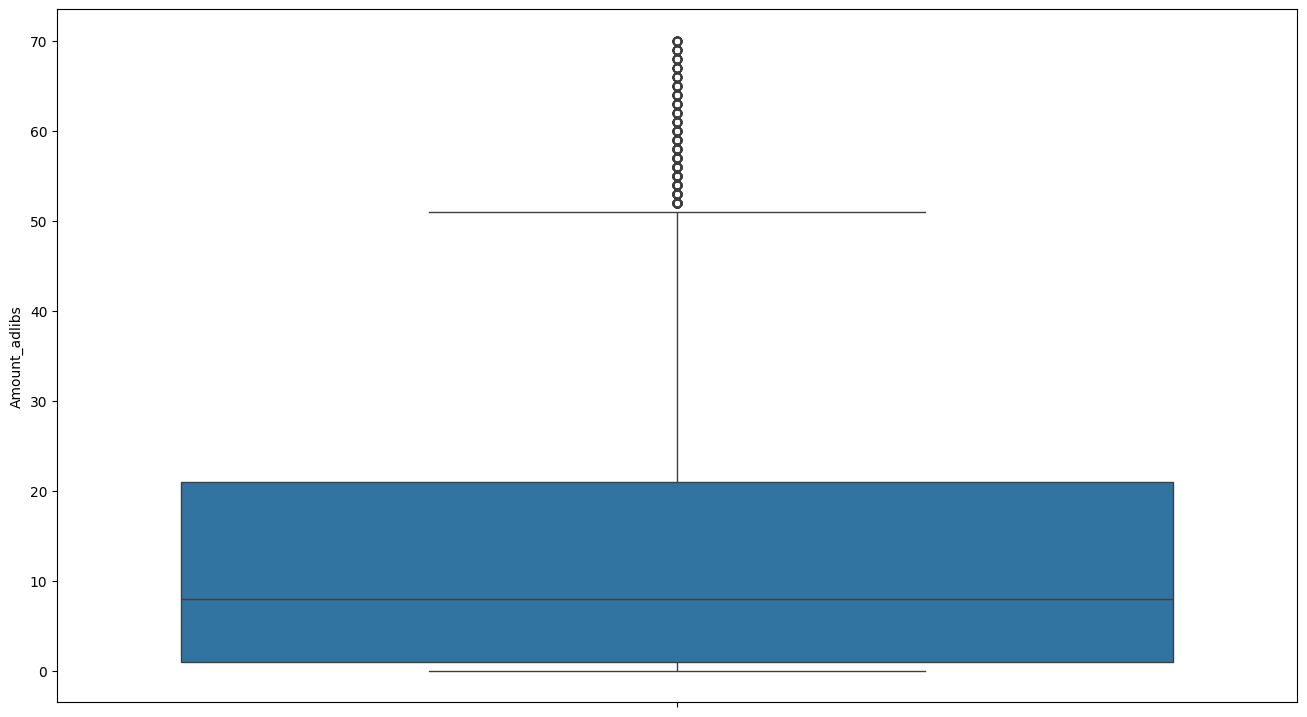

In [76]:
plt.figure(figsize=(16,9))
sns.boxplot(
    data=lyrics[lyrics['Amount_adlibs'] < lyrics['Amount_adlibs'].quantile(0.99)],
    y='Amount_adlibs')

plt.title("", fontweight='bold')
plt.ylabel("Amount_adlibs")
plt.show()

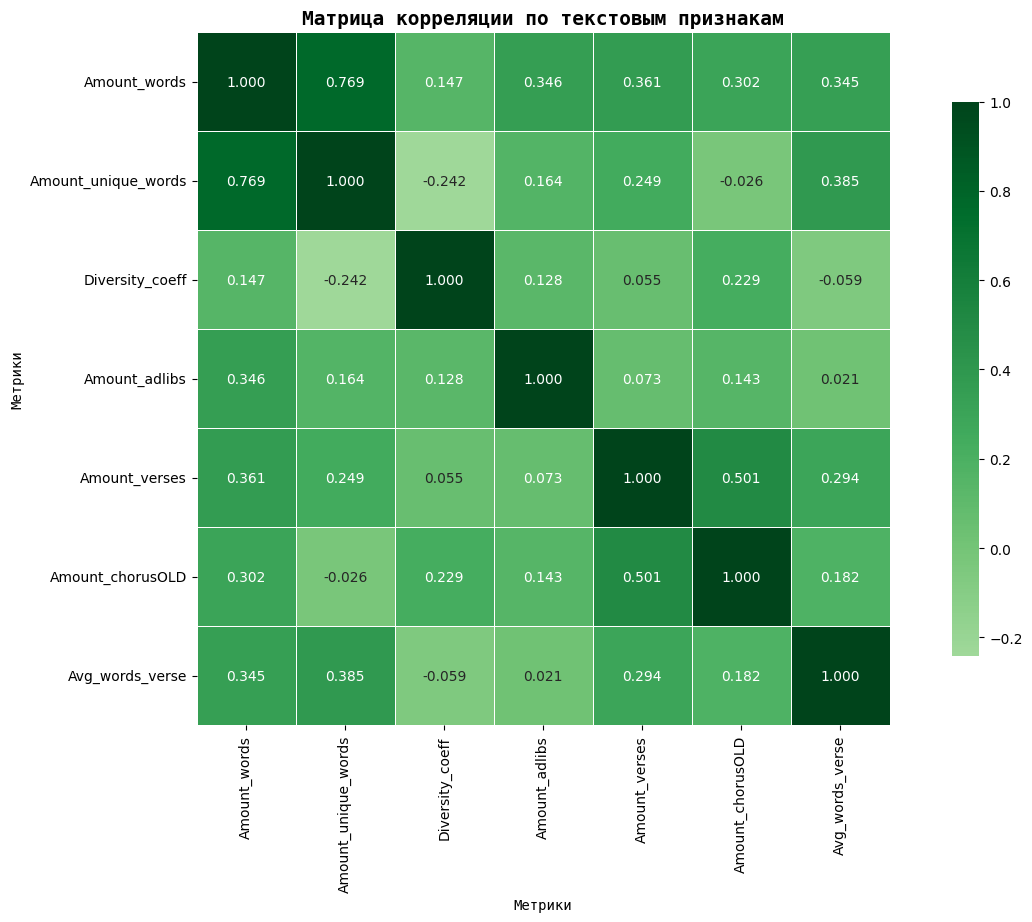

In [77]:
plt.figure(figsize=(16, 9))

sns.heatmap(lyrics[['Amount_words', 'Amount_unique_words', 'Diversity_coeff',	'Amount_adlibs',	'Amount_verses',	'Amount_chorusOLD', 'Avg_words_verse']].corr(),
            annot=True,
            cmap='Greens',         # близкий к #1DB954 фирменный Spotify-зелёный
            center=0,
            square=True,
            fmt='.3f',
            linewidths=0.5,
            cbar_kws={'shrink': 0.8}
)
plt.title("Матрица корреляции по текстовым признакам",
          fontsize=14,
          fontweight="bold",
          fontname="monospace")

plt.xlabel("Метрики",
           fontsize=10,
           fontname="monospace")

plt.ylabel("Метрики",
           fontsize=10,
           fontname="monospace")
plt.show()

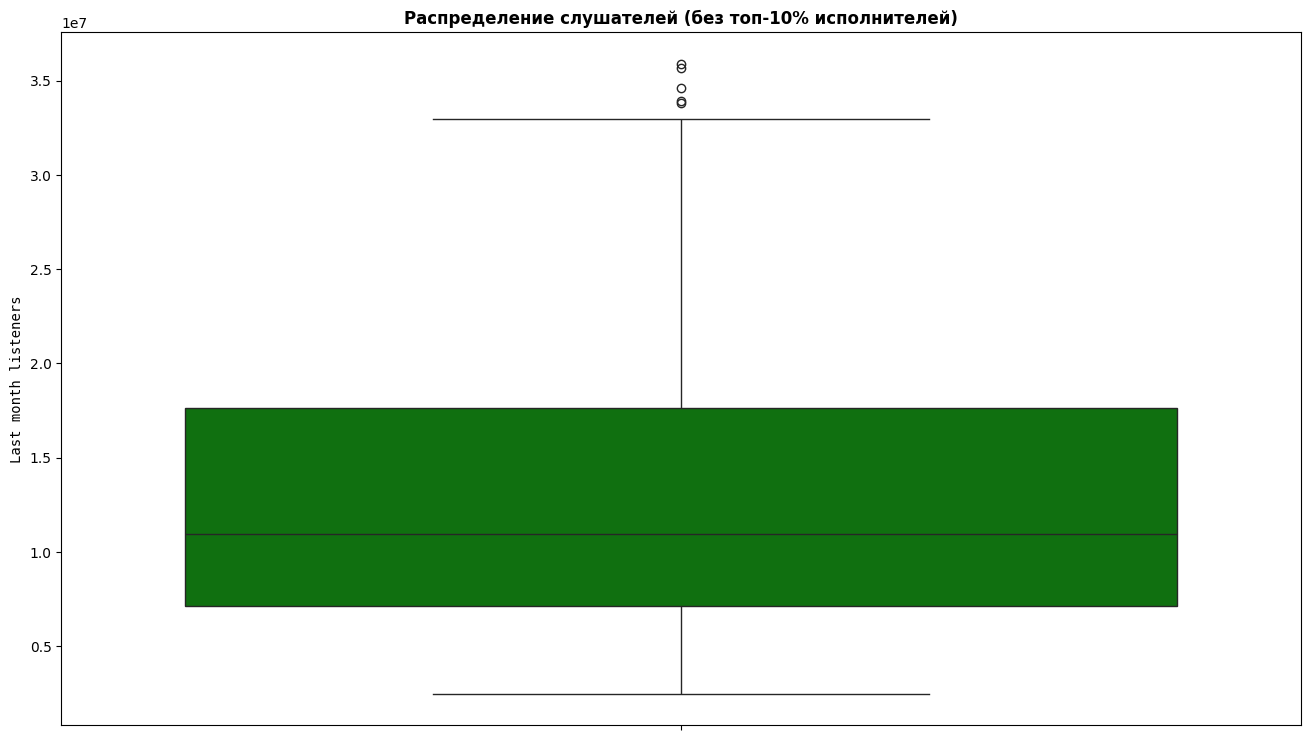

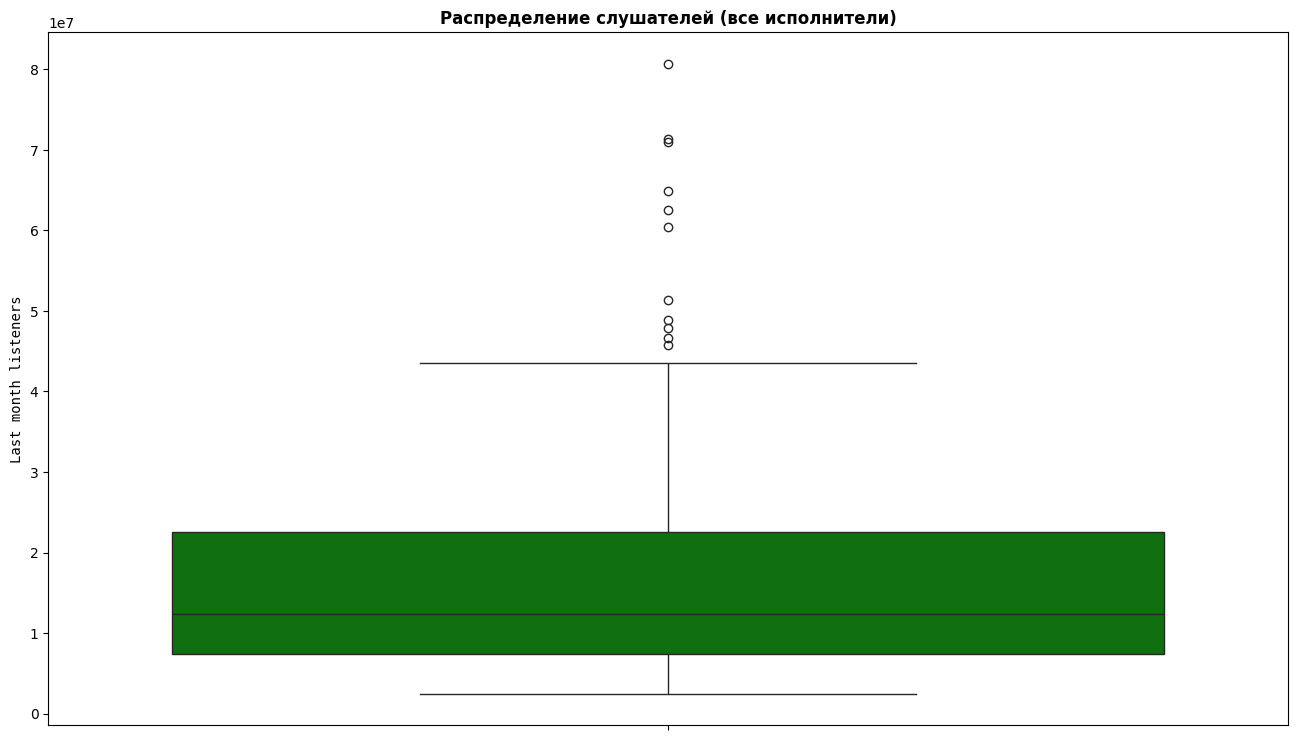

In [79]:
artists_data = pd.read_csv('datasets/artists_dataset.csv', index_col=0)
artists_data1 = artists_data[artists_data['last_month_listeners'] < artists_data['last_month_listeners'].quantile(0.9)]

plt.figure(figsize=(16,9))
sns.boxplot(
    data=artists_data1,
    y='last_month_listeners',
    color='green')

plt.title("", fontweight='bold')
plt.ylabel("Last month listeners", fontsize=10,
    fontname='monospace')
plt.title("Распределение слушателей (без топ-10% исполнителей)", fontweight='bold')
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(
    data=artists_data,
    y='last_month_listeners',
    color='green')

plt.title("", fontweight='bold')
plt.ylabel("Last month listeners", fontsize=10,
    fontname='monospace')
plt.title("Распределение слушателей (все исполнители)", fontweight='bold')
plt.show()

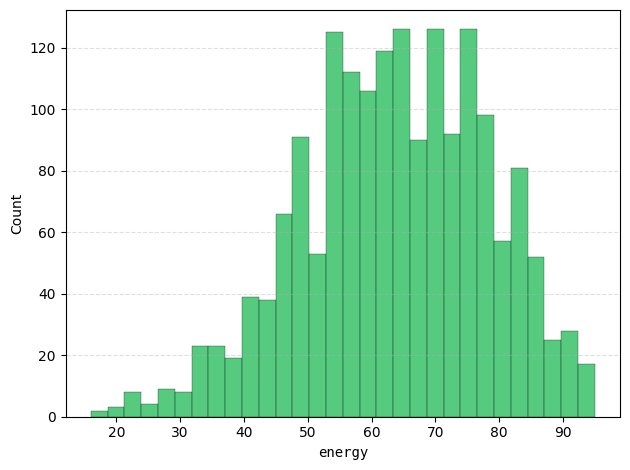

In [81]:
sns.histplot(x=melodies['energy'], bins=30, color='#1DB954', linewidth=0.2)

plt.xlabel("energy",
            fontsize=10,
            fontname="monospace")
plt.grid(axis="y",      
        linestyle="--",
        alpha=0.4)

plt.tight_layout()
plt.show()

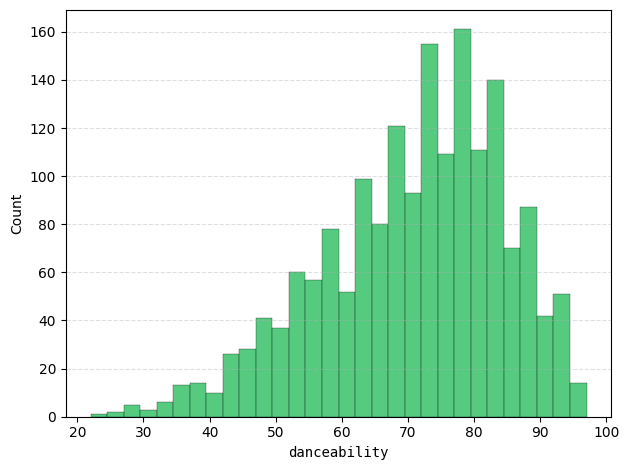

In [82]:
sns.histplot(x=melodies['danceability'], bins=30, color='#1DB954', linewidth=0.2)

plt.xlabel("danceability",
            fontsize=10,
            fontname="monospace")
plt.grid(axis="y",      
        linestyle="--",
        alpha=0.4)

plt.tight_layout()
plt.show()

In [70]:
dataset = pd.read_csv('datasets/final_data.csv', index_col=0)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset['Scalared_popularity']= scaler.fit_transform(dataset[['popularity_track']]) #скалируем
dataset = dataset.dropna()
X = dataset[['duration_min', 'release_date', 'number_of_artists',
       'popularity_artist_mean','danceability', 'happiness',
       'acousticness', 'speechiness', 'loudness', 'album', 'compilation',
       'single', 'Diversity_coeff', 'Amount_adlibs', 'Amount_chorus',
       'Avg_words_verse']] #метрики, влияющие на результат
y = dataset[['Scalared_popularity']] #результат
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #разделили выборку

model = LinearRegression() #модель линейной регрессии
model.fit(X_train, y_train) #обучили
predict = model.predict(X_test) 
mae = mean_absolute_error(y_test, predict) #посмотрели погрешность при помощи метода mae
mse = mean_squared_error(y_test, predict)#метод наим квадратов
print(mae, mse)

0.733605976763723 0.831672579456728


In [72]:
print(dataset['Scalared_popularity'].max(),dataset['Scalared_popularity'].min())

4.245322452813252 -1.1772297068807263
